## Singapore Job Market – Phase 4 Insight Generation

This notebook computes the metrics and generates the plots referenced in
`reports/insights_catalog.md`.

- Uses the cleaned & transformed dataset from `data_cleaning.py`
- Exports summary tables into `reports/data/`
- Exports figures into `reports/figures/`

Adjust import paths as needed depending on where you run this notebook (project root vs `notebooks/` folder).

In [5]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure plots are reasonably sized
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

# Adjust path: notebook is inside /notebooks, so go one level up
PROJECT_ROOT = Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "SGJobData_clean.csv"

REPORTS_DIR = PROJECT_ROOT / 'reports'
FIGURES_DIR = REPORTS_DIR / 'figures'
DATA_DIR = REPORTS_DIR / 'data'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)


### 0. Load cleaned dataset

In [6]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded cleaned dataset: {df.shape[0]:,} rows × {df.shape[1]:,} columns")


Loaded cleaned dataset: 1,044,587 rows × 25 columns


### 0.1 Outlier cleaning & Helper columns

In [7]:
# Filter out salary outliers (re-use thresholds from EDA)
lower_thr = df["average_salary"].quantile(0.01)
upper_thr = df["average_salary"].quantile(0.99)
df = df[
    (df["average_salary"] >= lower_thr)
    & (df["average_salary"] <= upper_thr)
].copy()

print(f"After outlier removal: {len(df):,} rows remain "
      f"({100 * len(df) / len(df):.2f}% of original).")

# Date columns
df['posting_date'] = pd.to_datetime(df['metadata_originalPostingDate'], errors='coerce')
df['expiry_date'] = pd.to_datetime(df['metadata_expiryDate'], errors='coerce')
df['posting_month'] = df['posting_date'].dt.to_period('M').astype('string')

# Days open
df['days_open'] = (df['expiry_date'] - df['posting_date']).dt.days

# Applications per vacancy (avoid division by zero)
df['apps_per_vacancy'] = (
    df['metadata_totalNumberJobApplication'] /
    df['numberOfVacancies'].replace(0, pd.NA)
)

df[['posting_date', 'expiry_date', 'posting_month', 'days_open', 'apps_per_vacancy']].head()

After outlier removal: 1,024,735 rows remain (100.00% of original).


,posting_date,expiry_date,posting_month,days_open,apps_per_vacancy
0,2023-03-30,2023-05-08,2023-03,39,5.0
1,2023-04-08,2023-05-08,2023-04,30,0.0
2,2023-04-08,2023-04-22,2023-04,14,7.0
3,2023-04-08,2023-05-08,2023-04,30,6.0
4,2023-04-08,2023-05-08,2023-04,30,1.0


### 1. Demand & Hiring Landscape

##### D1 – Hiring concentration

Top 10 sectors make up 67.94% of total postings.


,job_count,pct,cum_pct
primary_category,,,
Admin / Secretarial,101423,9.897486,9.897486
Engineering,99040,9.664938,19.562423
Information Technology,97679,9.532123,29.094546
Accounting / Auditing / Taxation,77663,7.578837,36.673384
Building and Construction,73619,7.184199,43.857583
Customer Service,63491,6.195846,50.053428
F&B,58758,5.733970,55.787399
Banking and Finance,44013,4.295062,60.082460
Logistics / Supply Chain,43981,4.291939,64.374399


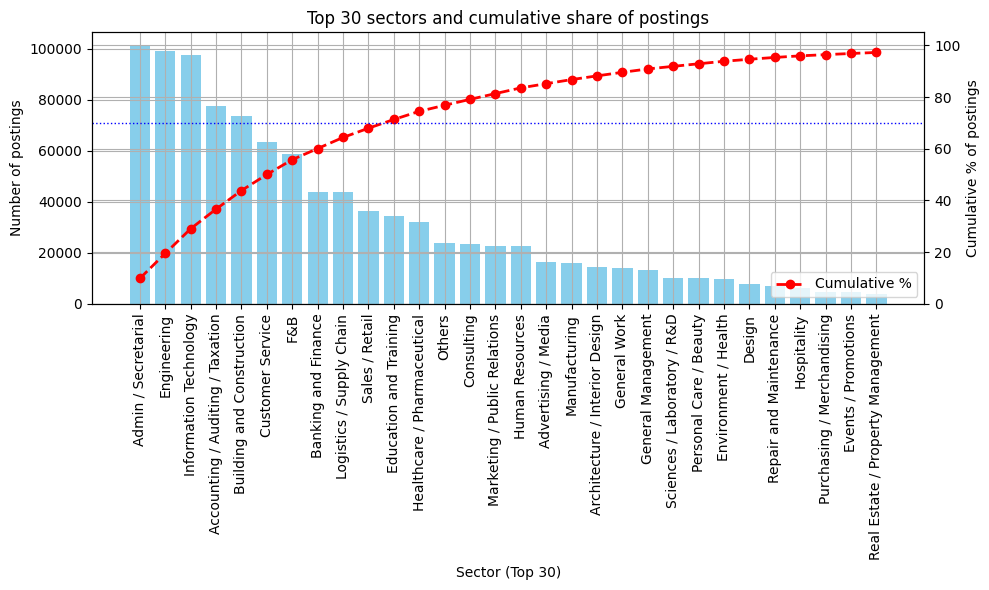

In [10]:
top_n = 30

# 1️⃣ Count postings by sector
sector_counts = (
    df.groupby("primary_category")["metadata_jobPostId"]
      .nunique()
      .sort_values(ascending=False)
)

# 2️⃣ Compute % of total and cumulative %
sector_stats = (
    sector_counts
    .to_frame(name="job_count")
    .assign(
        pct=lambda x: 100 * x["job_count"] / x["job_count"].sum(),
        cum_pct=lambda x: x["pct"].cumsum()
    )
)

# 3️⃣ Identify which sectors make up ~70% of postings
threshold_sector = sector_stats[sector_stats["cum_pct"] <= 70]
print(
    f"Top {len(threshold_sector)} sectors make up "
    f"{threshold_sector['cum_pct'].iloc[-1]:.2f}% of total postings."
)
display(threshold_sector)

# 4️⃣ Save for reporting
sector_stats.to_csv(DATA_DIR / "D1_sector_postings_by_category.csv")

# 5️⃣ Pareto-style chart (bar + red cumulative % line)
head_stats = sector_stats.head(top_n)
x_pos = np.arange(len(head_stats))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars: job count
bars = ax1.bar(x_pos, head_stats["job_count"], color="skyblue")
ax1.set_xlabel(f"Sector (Top {top_n})")
ax1.set_ylabel("Number of postings")
ax1.set_title(f"Top {top_n} sectors and cumulative share of postings")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(head_stats.index, rotation=90)

# Line: cumulative % (red)
ax2 = ax1.twinx()
ax2.plot(
    x_pos,
    head_stats["cum_pct"].to_numpy(),
    color="red",
    marker="o",
    linestyle="--",
    linewidth=2,
    label="Cumulative %"
)
ax2.set_ylabel("Cumulative % of postings")
ax2.axhline(70, color="blue", linestyle=":", linewidth=1)
ax2.set_ylim(0, 105)

# Optional: show legend for cumulative % line
ax2.legend(loc="lower right")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "D1_sector_cumulative_share.png", dpi=150)
plt.show()


##### D2 – Heavy recruiters vs long-tail employers

2213 companies make up 70.00% of total postings.


,job_count,pct,cum_pct
postedCompany_name,,,
The Supreme Hr Advisory Pte. Ltd.,61486,6.000185,6.000185
Recruitpedia Pte. Ltd.,50151,4.894046,10.894231
Recruit Express Pte Ltd,32200,3.142276,14.036507
Anradus Pte. Ltd.,25774,2.515187,16.551694
Recruit Expert Pte. Ltd.,21591,2.106984,18.658678
Persolkelly Singapore Pte. Ltd.,12960,1.264717,19.923395
Talent Trader Group Pte. Ltd.,8424,0.822066,20.745461
Rk Recruitment Pte. Ltd.,8174,0.797670,21.543131
Recruit Lync Pte. Ltd.,5842,0.570099,22.113229



Herfindahl–Hirschman Index (HHI) for company posting shares: 90
Market structure: competitive / long-tail (HHI < 1500).


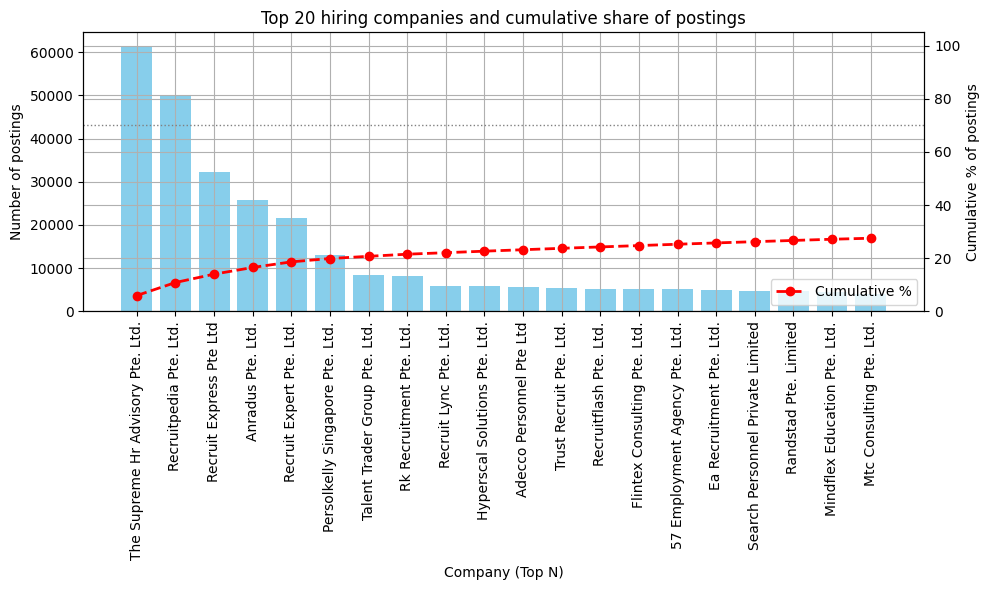

In [41]:
top_n = 20

# 1️⃣ Count job postings per company
company_counts = (
    df.groupby("postedCompany_name")["metadata_jobPostId"]
      .nunique()
      .sort_values(ascending=False)
)

# 2️⃣ Compute % of total and cumulative %
company_stats = (
    company_counts
    .to_frame(name="job_count")
    .assign(
        pct=lambda x: 100 * x["job_count"] / x["job_count"].sum(),
        cum_pct=lambda x: x["pct"].cumsum()
    )
)

# 3️⃣ Identify companies that make up ~70% of all postings
threshold_companies = company_stats[company_stats["cum_pct"] <= 70]
print(
    f"{len(threshold_companies)} companies make up "
    f"{threshold_companies['cum_pct'].iloc[-1]:.2f}% of total postings."
)
display(company_stats.head(top_n))

# Save full stats for reporting
company_stats.to_csv(DATA_DIR / "D2_company_postings_distribution.csv")

# 4️⃣ Market concentration metric – Herfindahl–Hirschman Index (HHI)
shares = (company_stats["pct"] / 100).to_numpy()   # convert % to fractions
hhi = (shares ** 2).sum() * 10_000
print(f"\nHerfindahl–Hirschman Index (HHI) for company posting shares: {hhi:.0f}")

if hhi < 1500:
    print("Market structure: competitive / long-tail (HHI < 1500).")
elif hhi < 2500:
    print("Market structure: moderately concentrated (1500 ≤ HHI < 2500).")
else:
    print("Market structure: highly concentrated (HHI ≥ 2500).")

# 5️⃣ Pareto-style chart
head_stats = company_stats.head(top_n)
x_pos = np.arange(len(head_stats))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars: job counts
bars = ax1.bar(x_pos, head_stats["job_count"], color="skyblue")
ax1.set_xlabel("Company (Top N)")
ax1.set_ylabel("Number of postings")
ax1.set_title(f"Top {top_n} hiring companies and cumulative share of postings")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(head_stats.index, rotation=90)

# Line: cumulative % (red)
ax2 = ax1.twinx()
ax2.plot(
    x_pos,
    head_stats["cum_pct"].to_numpy(),
    color="red",
    marker="o",
    linestyle="--",
    linewidth=2,
    label="Cumulative %"
)
ax2.set_ylabel("Cumulative % of postings")
ax2.axhline(70, color="gray", linestyle=":", linewidth=1)
ax2.set_ylim(0, 105)
ax2.legend(loc="lower right")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "D2_top20_companies_pareto.png", dpi=150)
plt.show()


##### D3 – Executive-level roles dominate

positionLevels
Executive            252485
Junior Executive     166680
Non-executive        128950
Fresh/entry level    114617
Professional         108440
Manager              108350
Senior Executive      99632
Middle Management     25934
Senior Management     19647
Name: count, dtype: int64

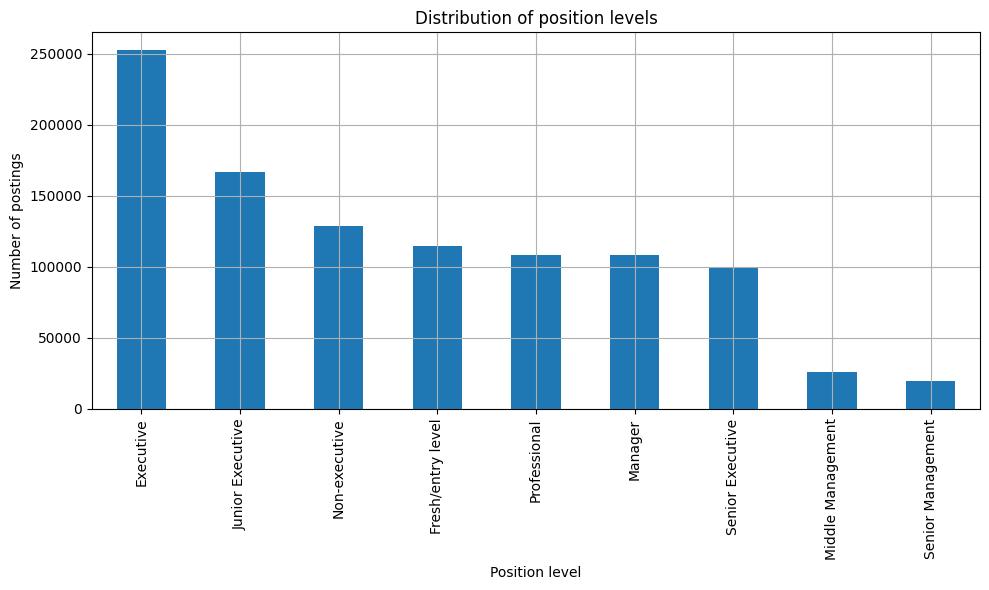

In [40]:
level_counts = df['positionLevels'].value_counts(dropna=False)
display(level_counts)

level_counts.to_csv(DATA_DIR / 'D3_position_level_distribution.csv')

plt.figure()
level_counts.plot(kind='bar')
plt.ylabel('Number of postings')
plt.xlabel('Position level')
plt.title('Distribution of position levels')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'D3_position_level_distribution.png', dpi=150)
plt.show()

##### D4 – Seasonal posting volume

posting_month
2022-10      171
2022-11      581
2022-12     1158
2023-01     2706
2023-02     5739
2023-03    19093
2023-04    32582
2023-05    69137
2023-06    69355
2023-07    81438
2023-08    82440
2023-09    75183
2023-10    78621
2023-11    70818
2023-12    59840
2024-01    79139
2024-02    67433
2024-03    77908
2024-04    79829
2024-05    71564
Name: metadata_jobPostId, dtype: int64

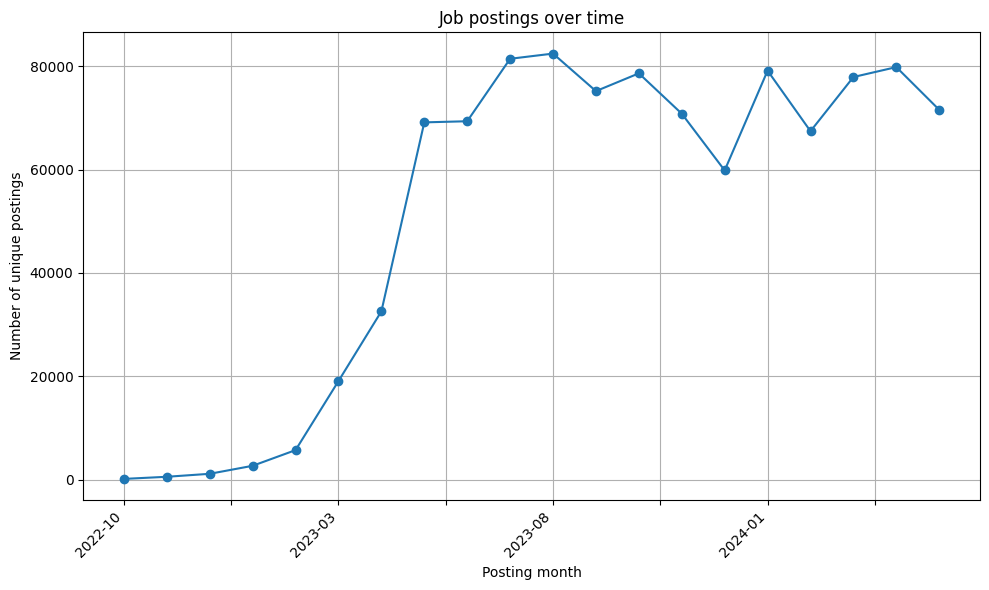

In [42]:
monthly_counts = (
    df.groupby('posting_month')['metadata_jobPostId']
      .nunique()
      .sort_index()
)
display(monthly_counts)

monthly_counts.to_csv(DATA_DIR / 'D4_postings_by_month.csv')

plt.figure()
monthly_counts.plot(marker='o')
plt.ylabel('Number of unique postings')
plt.xlabel('Posting month')
plt.title('Job postings over time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'D4_postings_by_month.png', dpi=150)
plt.show()

### 2. Salary & Benchmarking

##### 2.0 Salary outlier filtering (1%–99% quantiles)

In [45]:
upper_thr = df['average_salary'].quantile(0.99)
lower_thr = df['average_salary'].quantile(0.01)
print(f"Upper Threshold: {upper_thr:,.0f}  |  Lower Threshold: {lower_thr:,.0f}")

df_sal = df[(df['average_salary'] >= lower_thr) & (df['average_salary'] <= upper_thr)].copy()
df_sal['average_salary'].describe(percentiles=[0.25, 0.5, 0.75])

Upper Threshold: 14,000  |  Lower Threshold: 1,250


count    1.004972e+06
mean     4.491113e+03
std      2.299111e+03
min      1.250000e+03
25%      3.000000e+03
50%      3.800000e+03
75%      5.340250e+03
max      1.400000e+04
Name: average_salary, dtype: float64

##### S1 – IT & Consulting pay the most

,count,mean,median
primary_category,,,
Information Technology,94264,6782.173454,6750.0
Legal,2936,6924.216281,6500.0
Risk Management,965,7078.202591,6500.0
Banking and Finance,41620,6447.567359,5750.0
Insurance,3018,5752.758118,5000.0
Sciences / Laboratory / R&D,10152,5096.108649,4862.5
Consulting,22577,5803.030584,4750.0
Public / Civil Service,701,4550.892297,4500.0
Engineering,98103,4834.637391,4250.0


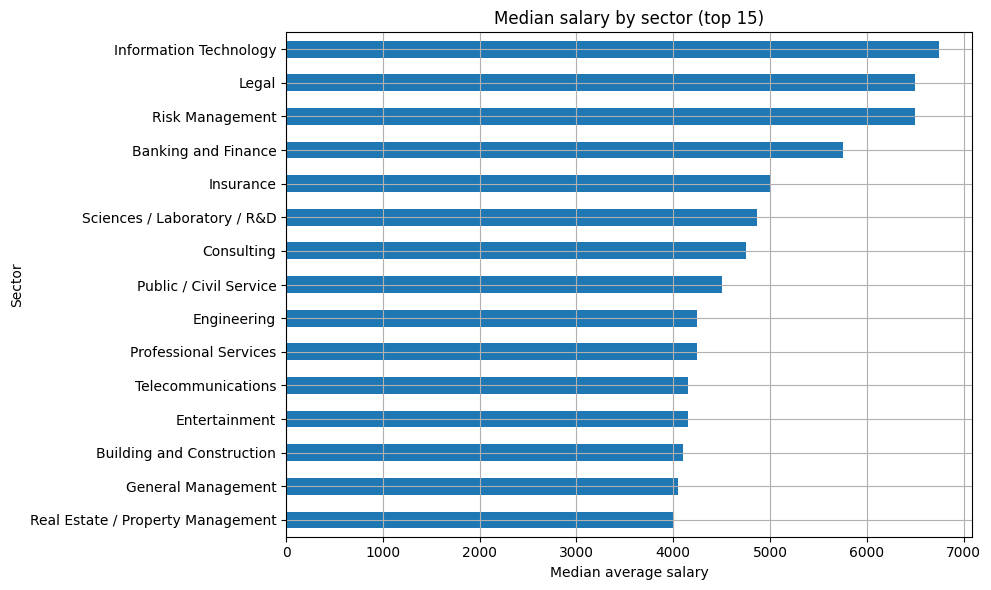

In [47]:
top_n = 15
sector_salary = (
    df_sal.groupby('primary_category')['average_salary']
      .agg(count='count', mean='mean', median='median')
      .sort_values('median', ascending=False)  # type: ignore
)

# Explicitly tell Pandas which column to sort by
# sector_salary = sector_salary.sort_values(by='median', ascending=False)

display(sector_salary.head(top_n))

sector_salary.to_csv(DATA_DIR / 'S1_sector_salary_stats.csv')

plt.figure()
sector_salary.head(15)['median'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Median average salary')
plt.ylabel('Sector')
plt.title('Median salary by sector (top 15)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'S1_sector_median_salary.png', dpi=150)
plt.show()

##### S2 – Top-paying job titles

,job_count,avg_salary
title,,
Director (recruitment),7,14000.000000
"Senior Portfolio Manager (urgent/investment/sme/s$18,000 Higher)",99,14000.000000
"Investment Fund Manager (urgent/investment/sme/s$18,000 Higher)",12,14000.000000
Senior Vessel Manager,5,14000.000000
Recruitment Consultant - Head,5,14000.000000
Sales Director #65632,11,14000.000000
"Vice President, Cybersecurity",22,14000.000000
Marine Vessel Cargo Operations Manager - With Sailing Experience,5,14000.000000
Director Of Operations (retail),5,14000.000000


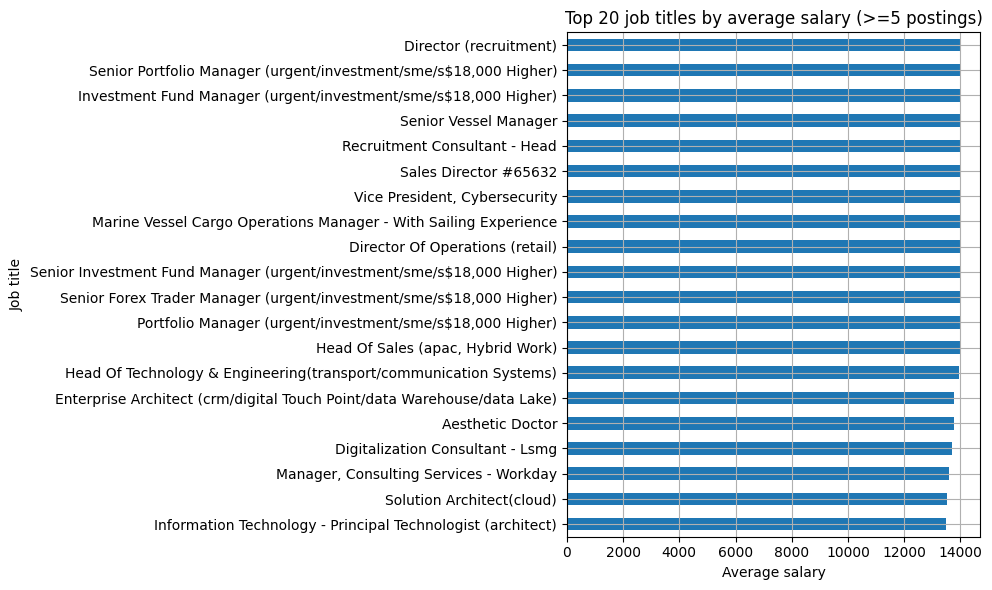

In [49]:
count_n=5
top_n = 20

title_salary = (
    df_sal.groupby('title')['average_salary']
      .agg(job_count='count', avg_salary='mean')
      .sort_values('avg_salary', ascending=False)  # type: ignore
)
title_salary_filtered = title_salary[title_salary["job_count"] >= count_n]
top_titles = title_salary_filtered.nlargest(top_n, "avg_salary")
display(top_titles)

top_titles.to_csv(DATA_DIR / 'S2_top20_titles_by_avg_salary.csv')

plt.figure()
top_titles['avg_salary'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Average salary')
plt.ylabel('Job title')
plt.title('Top 20 job titles by average salary (>=5 postings)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'S2_top20_titles_by_avg_salary.png', dpi=150)
plt.show()

##### S3 – Experience vs salary curve

,job_count,avg_salary,median_salary
minimumYearsExperience,,,
0,103327,3158.252011,2800.0
1,257629,3249.627969,3000.0
2,217881,3789.855986,3500.0
3,167541,4712.227112,4250.0
4,34406,5863.220528,5500.0
5,141144,6043.296817,5500.0
6,19463,7460.872091,8000.0
7,10205,8193.912690,8000.0
8,25120,7950.961704,8000.0


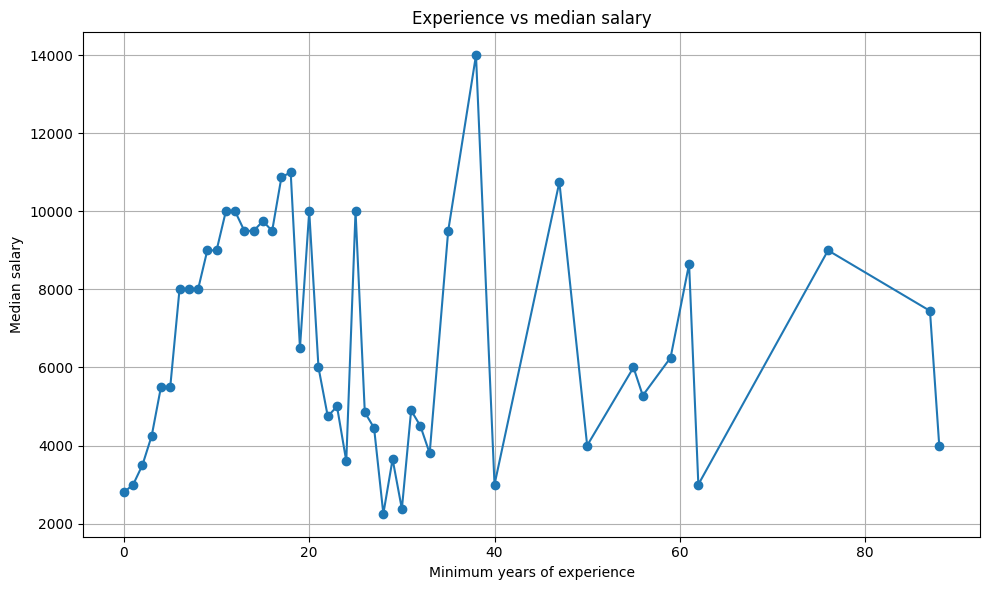

In [50]:
exp_salary = (
    df_sal.groupby('minimumYearsExperience')['average_salary']
      .agg(job_count='count', avg_salary='mean', median_salary='median')
      .sort_index()
)
display(exp_salary)

exp_salary.to_csv(DATA_DIR / 'S3_experience_vs_salary.csv')

plt.figure()
plt.plot(exp_salary.index, exp_salary['median_salary'], marker='o')
plt.xlabel('Minimum years of experience')
plt.ylabel('Median salary')
plt.title('Experience vs median salary')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'S3_experience_vs_salary.png', dpi=150)
plt.show()

##### S4 – Seniority premium within sectors

,primary_category,positionLevels,job_count,median_salary
0,Accounting / Auditing / Taxation,Executive,23458,3500.0
1,Accounting / Auditing / Taxation,Fresh/entry level,6078,2650.0
2,Accounting / Auditing / Taxation,Junior Executive,16358,3050.0
3,Accounting / Auditing / Taxation,Manager,9058,6500.0
4,Accounting / Auditing / Taxation,Middle Management,1370,6250.0


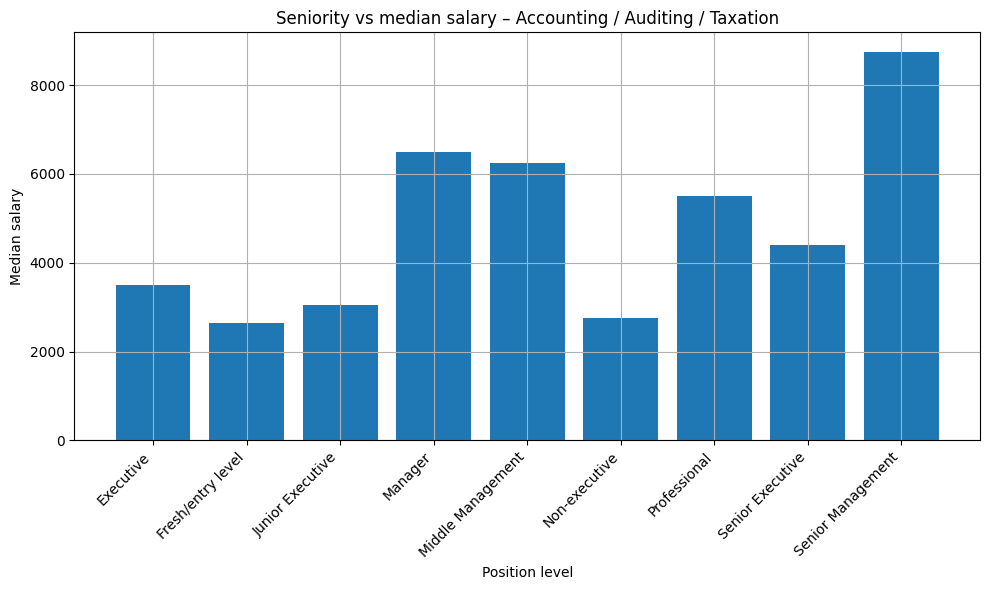

In [51]:
seniority_salary = (
    df_sal.groupby(['primary_category', 'positionLevels'])['average_salary']
      .agg(job_count='count', median_salary='median')
      .reset_index()
)
display(seniority_salary.head())

seniority_salary.to_csv(DATA_DIR / 'S4_seniority_salary_by_sector.csv', index=False)

# Example: plot a single sector for inspection
example_sector = seniority_salary['primary_category'].dropna().unique()[0]
sub = seniority_salary[seniority_salary['primary_category'] == example_sector]

plt.figure()
plt.bar(sub['positionLevels'], sub['median_salary'])
plt.xlabel('Position level')
plt.ylabel('Median salary')
plt.title(f'Seniority vs median salary – {example_sector}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'S4_seniority_salary_example_sector.png', dpi=150)
plt.show()

### 3. Competition & Market Tightness

##### C1 – High applicant pressure in IT (apps per vacancy)

,median_apps,avg_apps,count
primary_category,,,
Risk Management,1.000000,3.502858,1024
Banking and Finance,0.500000,3.028400,44013
Human Resources,0.333333,3.094914,22657
Accounting / Auditing / Taxation,0.000000,2.149386,77663
Purchasing / Merchandising,0.000000,2.290810,4761
Marketing / Public Relations,0.000000,2.646112,22844
Medical / Therapy Services,0.000000,0.604782,3962
Others,0.000000,1.939698,23953
Personal Care / Beauty,0.000000,0.133568,10190


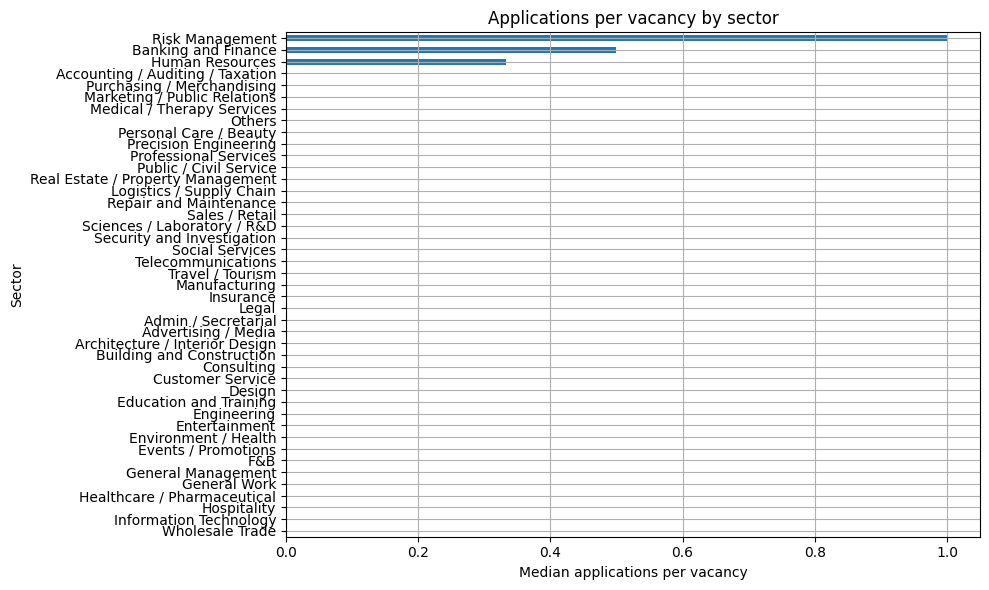

In [ ]:
sector_comp = (
    df.groupby('primary_category')['apps_per_vacancy']
      .agg(median_apps='median', avg_apps='mean', count='count')
      .sort_values('median_apps', ascending=False)
)
display(sector_comp)

sector_comp.to_csv(DATA_DIR / 'C1_apps_per_vacancy_by_sector.csv')

plt.figure()
sector_comp['median_apps'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Median applications per vacancy')
plt.ylabel('Sector')
plt.title('Applications per vacancy by sector')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'C1_apps_per_vacancy_by_sector.png', dpi=150)
plt.show()

##### C2 – Hard-to-fill specialized roles (days open & reposts)

,job_count,median_days_open,avg_reposts
title,,,
Zk18 - Audit Associate,13,166.0,1.000000
Supervisor And General Foremen (construction Trade),5,160.0,1.200000
Shipping Assistant / Junior – 1-2 Experience Can Apply (bedok),5,155.0,1.600000
Facilities Manager / Executive,7,145.0,0.571429
Industrial Assistant Engineer,9,142.0,0.777778
Senior/ Planner,7,141.0,0.714286
Sales Executive /sales Engineer / Korean Speaking / Equipment/devices/machine/components,7,138.0,1.571429
Tunnel Boring Machine (tbm) Operator,7,129.0,1.000000
Information Technology - Principal Technologist (cloud),5,127.0,0.600000


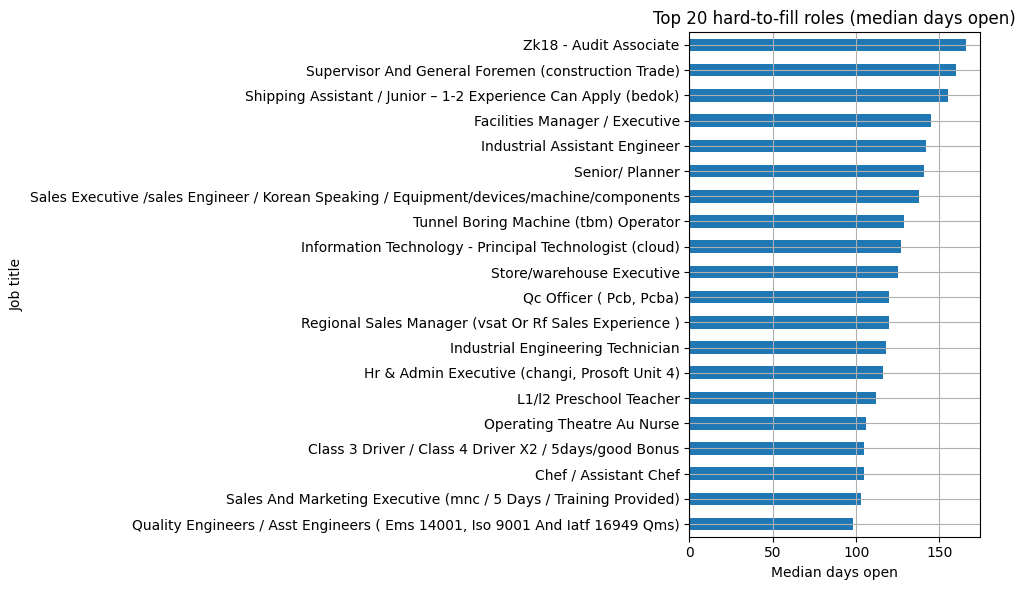

In [53]:
title_difficulty = (
    df.groupby('title')
      .agg(
          job_count=('metadata_jobPostId', 'nunique'),
          median_days_open=('days_open', 'median'),
          avg_reposts=('metadata_repostCount', 'mean')
      )
)

title_difficulty = title_difficulty[title_difficulty['job_count'] >= 5]
hard_to_fill = title_difficulty.sort_values(
    ['median_days_open', 'avg_reposts'], ascending=False
).head(20)

display(hard_to_fill)

hard_to_fill.to_csv(DATA_DIR / 'C2_hard_to_fill_titles.csv')

plt.figure()
hard_to_fill['median_days_open'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Median days open')
plt.ylabel('Job title')
plt.title('Top 20 hard-to-fill roles (median days open)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'C2_hard_to_fill_titles.png', dpi=150)
plt.show()

##### C3 – Quick-fill admin roles (median days open by sector)

,median_days_open,mean_days_open,count
primary_category,,,
Public / Civil Service,29.0,25.553495,701
Logistics / Supply Chain,30.0,25.962825,43981
Manufacturing,30.0,27.425009,16242
Marketing / Public Relations,30.0,27.522457,22844
Medical / Therapy Services,30.0,29.921757,3962
Others,30.0,28.667766,23953
Personal Care / Beauty,30.0,30.133562,10190
Precision Engineering,30.0,29.286885,732
Professional Services,30.0,27.099577,3545


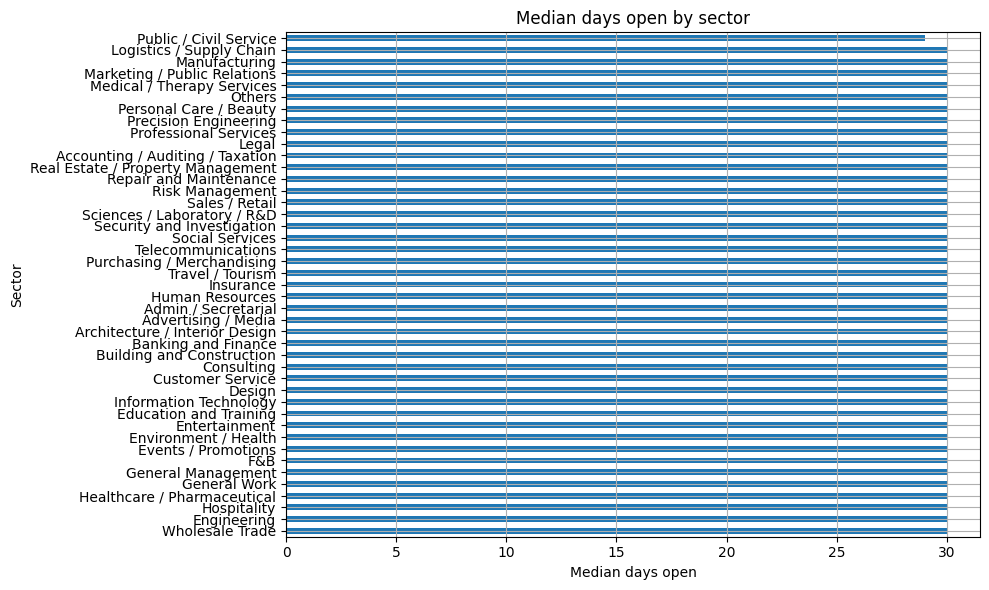

In [54]:
sector_days_open = (
    df.groupby('primary_category')['days_open']
      .agg(median_days_open='median', mean_days_open='mean', count='count')
      .sort_values('median_days_open')
)
display(sector_days_open)

sector_days_open.to_csv(DATA_DIR / 'C3_days_open_by_sector.csv')

plt.figure()
sector_days_open['median_days_open'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Median days open')
plt.ylabel('Sector')
plt.title('Median days open by sector')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'C3_days_open_by_sector.png', dpi=150)
plt.show()

### 4. Skills & Emerging Trends

##### 4.0 Data & AI role flagging

In [62]:
pattern = r"\b(Data|AI|Artificial Intelligence|Machine Learning|ML|Analytics)\b"
df['is_data_ai'] = df['title'].str.contains(pattern, case=False, regex=True, na=False)
df['is_data_ai'].value_counts()

/tmp/ipykernel_336175/3539663607.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_data_ai'] = df['title'].str.contains(pattern, case=False, regex=True, na=False)


is_data_ai
False    1011569
True       13166
Name: count, dtype: int64

##### K1 – Rise of Data & AI roles over time

,total_posts,data_ai_posts,data_ai_share_pct
posting_month,,,
2022-10,171,1,0.584795
2022-11,581,7,1.204819
2022-12,1158,7,0.604491
2023-01,2706,16,0.591279
2023-02,5739,58,1.010629
2023-03,19093,224,1.173205
2023-04,32582,421,1.292124
2023-05,69137,890,1.287299
2023-06,69355,840,1.211160


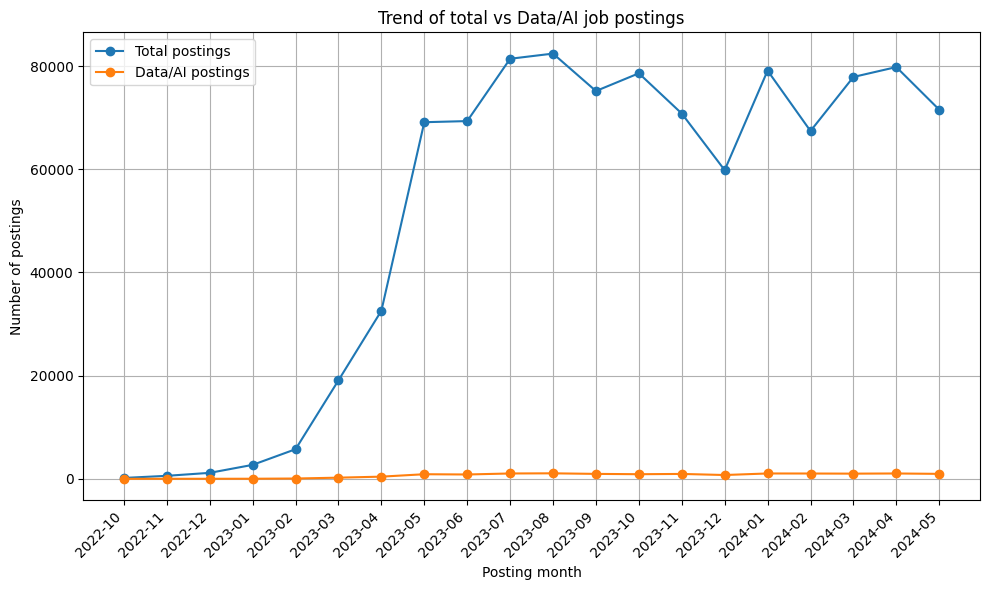

In [63]:
monthly_total = (
    df.groupby('posting_month')['metadata_jobPostId']
      .nunique()
)

monthly_data_ai = (
    df[df['is_data_ai']]
      .groupby('posting_month')['metadata_jobPostId']
      .nunique()
)

trend = pd.concat(
    [monthly_total.rename('total_posts'), monthly_data_ai.rename('data_ai_posts')],
    axis=1
).sort_index()

trend['data_ai_share_pct'] = (trend['data_ai_posts'] / trend['total_posts']) * 100
display(trend)

trend.to_csv(DATA_DIR / 'K1_data_ai_trend.csv')

plt.figure()
plt.plot(trend.index, trend['total_posts'], marker='o', label='Total postings')
plt.plot(trend.index, trend['data_ai_posts'], marker='o', label='Data/AI postings')
plt.xlabel('Posting month')
plt.ylabel('Number of postings')
plt.title('Trend of total vs Data/AI job postings')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'K1_data_ai_trend.png', dpi=150)
plt.show()

##### K2 – Data & AI roles across sectors

,data_ai_posts,total_posts,data_ai_share_pct
primary_category,,,
Information Technology,6319,97679,6.469149
Sciences / Laboratory / R&D,408,10281,3.968486
Risk Management,35,1024,3.417969
Banking and Finance,1239,44013,2.815077
Consulting,441,23437,1.881640
Insurance,50,3118,1.603592
Telecommunications,13,847,1.534829
Others,332,23953,1.386048
Engineering,1311,99040,1.323708


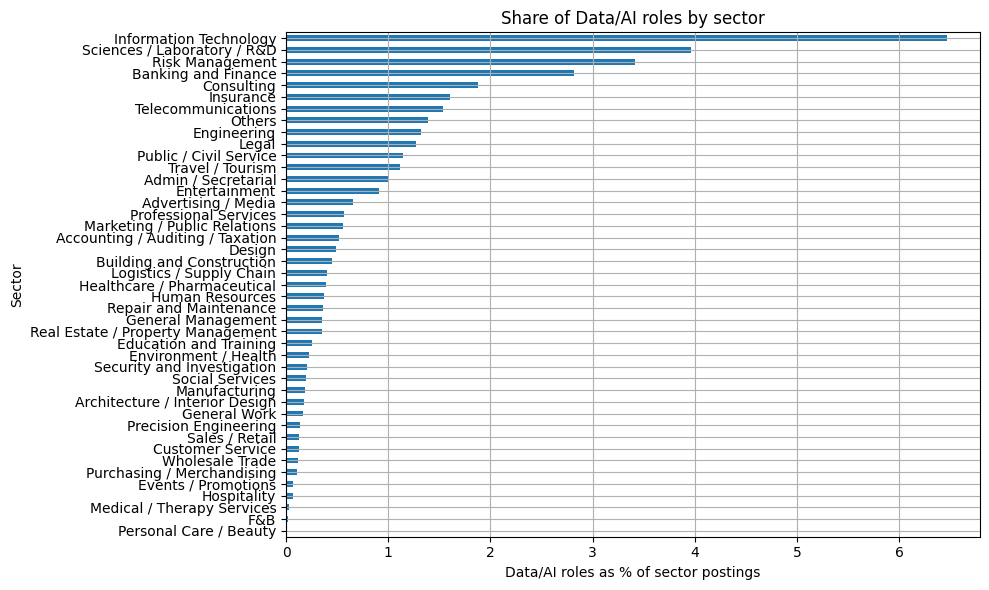

In [58]:
data_ai_by_sector = (
    df[df['is_data_ai']]
      .groupby('primary_category')['metadata_jobPostId']
      .nunique()
      .rename('data_ai_posts')
)

sector_totals = (
    df.groupby('primary_category')['metadata_jobPostId']
      .nunique()
      .rename('total_posts')
)

ai_sector_share = pd.concat([data_ai_by_sector, sector_totals], axis=1)
ai_sector_share['data_ai_share_pct'] = (
    ai_sector_share['data_ai_posts'] / ai_sector_share['total_posts'] * 100
)
ai_sector_share = ai_sector_share.sort_values('data_ai_share_pct', ascending=False)
display(ai_sector_share)

ai_sector_share.to_csv(DATA_DIR / 'K2_data_ai_share_by_sector.csv')

plt.figure()
ai_sector_share['data_ai_share_pct'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Data/AI roles as % of sector postings')
plt.ylabel('Sector')
plt.title('Share of Data/AI roles by sector')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'K2_data_ai_share_by_sector.png', dpi=150)
plt.show()

### 5. Operational / Posting Dynamics

##### O1 – Average posting lifespan

count    1.024735e+06
mean     2.840748e+01
std      1.802376e+01
min      1.000000e+00
25%      3.000000e+01
50%      3.000000e+01
75%      3.000000e+01
max      2.130000e+02
Name: days_open, dtype: float64

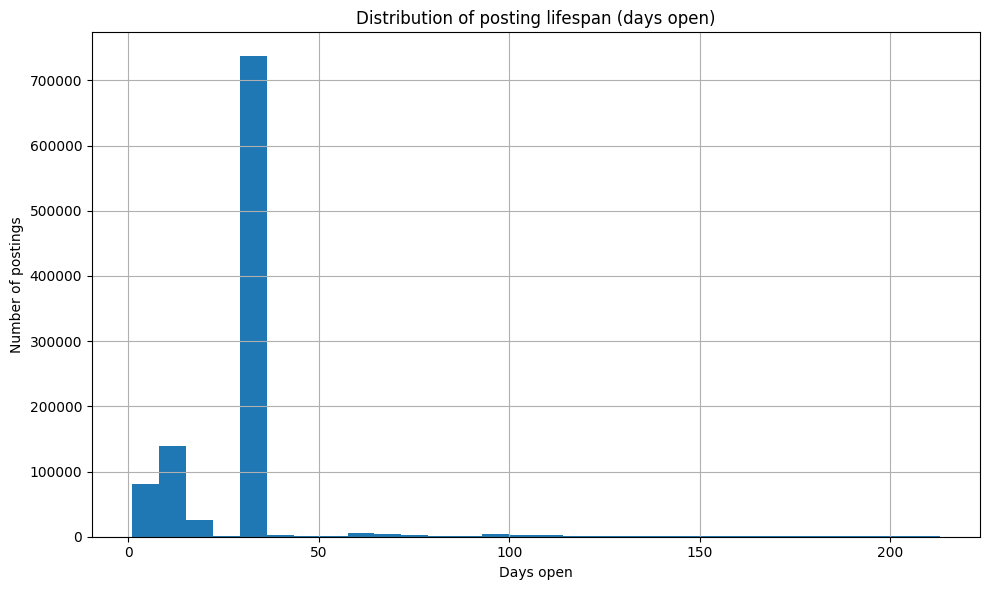

In [ ]:
days_open_desc = df['days_open'].describe()
display(days_open_desc)

days_open_desc.to_frame('days_onpe').to_csv(DATA_DIR / 'O1_days_open_summary.csv')

plt.figure()
df['days_open'].dropna().plot(kind='hist', bins=30)
plt.xlabel('Days open')
plt.ylabel('Number of postings')
plt.title('Distribution of posting lifespan (days open)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'O1_days_open_distribution.png', dpi=150)
plt.show()

##### O2 – Reposting signals hiring friction

metadata_repostCount
0    982747
1     27530
2     14458
Name: count, dtype: int64

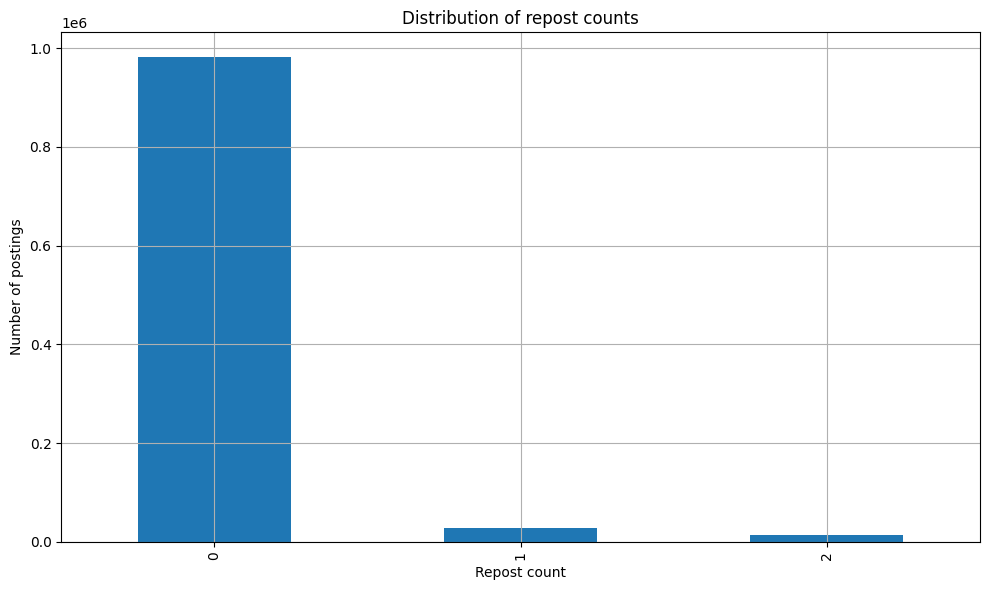

In [60]:
repost_counts = df['metadata_repostCount'].value_counts().sort_index()
display(repost_counts)

repost_counts.to_csv(DATA_DIR / 'O2_repost_count_distribution.csv')

plt.figure()
repost_counts.plot(kind='bar')
plt.xlabel('Repost count')
plt.ylabel('Number of postings')
plt.title('Distribution of repost counts')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'O2_repost_count_distribution.png', dpi=150)
plt.show()

##### O3 – Mid-year peak, late-year slowdown

This insight reuses the monthly counts from **D4**, but you can add extra annotation / summary here if needed.

### 6. KPI Summary

In [61]:
kpis = {
    'total_postings': df['metadata_jobPostId'].nunique(),
    'total_companies': df['postedCompany_name'].nunique(),
    'total_sectors': df['primary_category'].nunique(),
    'median_salary_overall': df_sal['average_salary'].median(),
    'avg_apps_per_vacancy': df['apps_per_vacancy'].mean(),
    'avg_days_open': df['days_open'].mean(),
}
kpis_df = pd.Series(kpis, name='value')
display(kpis_df)

kpis_df.to_csv(DATA_DIR / 'KPI_summary.csv')

total_postings           1.024735e+06
total_companies          5.260000e+04
total_sectors            4.300000e+01
median_salary_overall    3.800000e+03
avg_apps_per_vacancy     1.621447e+00
avg_days_open            2.840748e+01
Name: value, dtype: float64